Todo:

Neue Implementation datasamplibg in xarray

- [ ] einfach über gesamtes Bild die targets erstellen mit coarsen
- [ ] dann nans auf 0 setzen
- [ ] durch meinen Filter jagen
- [ ] --> diejenigen mit vielen nans werden eh rausgefiltert
- [ ] dann wenn das input erstellt wird aus dem target funktion benutzen die einfach nan padded, alles was über die spatial bounds von unserem Datensatz geht (wird wh kaum passieren da unser datensatz ja quasi eh ge nan padded ist)

- [ ] Alternativ kann durch strengeres Filterkriterium auch einfach jedes Target mit irgendeinem Pixel als NaN rausgefiltert werden

old:
- Still have to do the nan cropping in xarray: crop in picture such that it is no nan padded
- Put all data into RAM (first build calulation tree, with .compute it will be loaded into RAM)
- Decide on whether to load the 128 x 128 chunks (because going from 32 x 32 we would indeed have more data but it would be highly correlated so it is questionable whether it boosts performance, but will delay training in prototyping)
- Also decide on whther to use every time step as target or directly chunk time into patches with .coarsen()

In [68]:
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import zarr

In [69]:
folder_path =  '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
data = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, data)
print(f'loading from: {load_path}')


loading from: /Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr


In [70]:
num_input_frames = 4
lead_time = 4
pt = num_input_frames + lead_time + 1 # how many time steps to include in a sample (i.e. context and target)
# 
# This defines the size of the patches, that are created by coarsen, filter is applies to these patches
py, px = 32, 32 #73, 137 # how many pixels in y and x direction
threshold = 0.1 # threshold for each pixel filter condition
threshold_percentage_pixels = 0.5


# In the current implementation py and px define the size of the target patches (previously those were the larger input patches)
# length_width_center_even as the same size as py and px, as the filter condition is calculated on the target patches

In [71]:
data = xr.open_dataset(load_path, engine='zarr') # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
data = data.squeeze()
# Set all NaNs to zero (this includes the NaN padding that the data naturally has)
data_no_nan = data.fillna(0)

In [72]:
print(data.dims)

FrozenMappingWarningOnValuesAccess({'time': 576, 'y': 1200, 'x': 1100})


In [73]:
data_shortened = data_no_nan.isel(
    time=slice(pt, -1)
)

In [74]:
print(data_shortened.dims)

FrozenMappingWarningOnValuesAccess({'time': 566, 'y': 1200, 'x': 1100})


In [96]:
# TODO: Crop the beginning of the data, such that we can always generate inputs from the target indecies


# partition the data into pt x py x px blocks using coarsen --> construct DatasetCoarsen object
# We are only choosing the targets here
coarse = data_shortened.coarsen(
    y = py,
    x = px,
    # time = 1, # TODO: This way we are making patches with 4 subsequent time frames. This way we are only taking a target every 'pt'th time step
    side = "left", # "left" means that the blocks are aligned to the left of the input
    boundary="trim") # boundary="trim" removes the last block if it is too small
# construct a new data set, where the patches are folded into a new dimension
patches = coarse.construct(
    # time = ("time_outer", "time_inner"),
    y = ("y_outer", "y_inner"),
    x = ("x_outer", "x_inner"))
# define a threshold for each pixel --> we get a pixel-wise boo
patches_boolean_pixelwise = patches > threshold
# We are calculating the percentage of pixels that passed filter (mean of boolean gives percentage of True)
patches_percentage_boo = patches_boolean_pixelwise.mean(("y_inner", "x_inner")) #, "time_inner"

valid_patches = patches_percentage_boo > threshold_percentage_pixels


In [109]:
# get the outer coordinates for all valid blocks (valid_time, valid_x, valid_y)
# (valid center is boolean, np.nonzero returns the indecies of the pixels that are non-zero, thus True)
valid_coords = np.array(np.nonzero(valid_patches.RV_recalc.values)).T
# For data loading purposes, we can use the valid_coords to get the corresponding blocks
# For example, to get a random block from the valid blocks, we can do the following:
# get a random element from the valid coordinates
sample_coord = valid_coords[np.random.randint(0, valid_coords.shape[0])]
# get the block at the sample coordinate. We are operating on the outer coordinates of the coarsed dataset
sample_block = patches.isel(
    # time_outer = sample_coord[0],
    time = sample_coord[0],

    y_outer = sample_coord[1],
    x_outer = sample_coord[2])
# Squeeze time dimension, which has len 1
# sample_block = sample_block.squeeze()

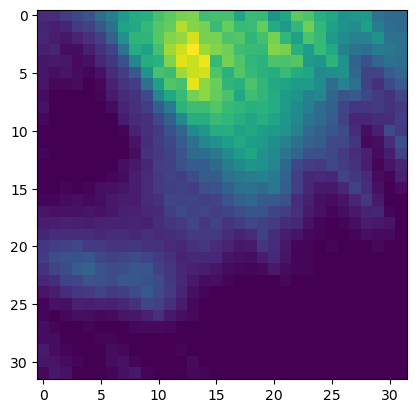

In [110]:
sample_block_vals = sample_block.RV_recalc.values.squeeze()
plt.figure()
plt.imshow(sample_block_vals, cmap='viridis')
# group by day xarray --> group by day to split in training and validation

In [99]:
(sample_block_vals > 0).any()

np.True_

In [95]:
valid_patches

<xarray.Dataset> Size: 750MB
Dimensions:                 (y_outer: 37, y_inner: 32, x_outer: 34,
                             x_inner: 32, time: 566)
Coordinates:
    latitude                (y_outer, y_inner, x_outer, x_inner) float64 10MB ...
    longitude               (y_outer, y_inner, x_outer, x_inner) float64 10MB ...
    missing_data_RV_recalc  (time) float32 2kB ...
    step                    timedelta64[ns] 8B 00:00:00
  * time                    (time) datetime64[ns] 5kB 2019-01-01T00:45:00 ......
    x                       (x_outer, x_inner) float64 9kB -543.5 ... 543.5
    y                       (y_outer, y_inner) float64 9kB -3.61e+03 ... -4.7...
Dimensions without coordinates: y_outer, y_inner, x_outer, x_inner
Data variables:
    RV_recalc               (time, y_outer, y_inner, x_outer, x_inner) bool 729MB ...
Attributes:
    crs:        +proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +...
    nodata:     nan
    notes:      The grid point RV_recalc[0,0] corresponds to the top-left cor...
    transform:  [1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.644724265573]

In [89]:
sample_block.items()

ItemsView(<xarray.Dataset> Size: 21kB
Dimensions:                 (y_inner: 32, x_inner: 32)
Coordinates:
    latitude                (y_inner, x_inner) float64 8kB 54.78 54.78 ... 54.5
    longitude               (y_inner, x_inner) float64 8kB 12.44 12.45 ... 12.89
    missing_data_RV_recalc  float32 4B ...
    step                    timedelta64[ns] 8B 00:00:00
    time                    datetime64[ns] 8B 2019-01-01T14:00:00
    x                       (x_inner) float64 256B 160.5 161.5 ... 190.5 191.5
    y                       (y_inner) float64 256B -3.77e+03 ... -3.801e+03
Dimensions without coordinates: y_inner, x_inner
Data variables:
    RV_recalc               (y_inner, x_inner) float32 4kB 0.0 0.0 ... 0.0 0.0
Attributes:
    crs:        +proj=stere +lat_0=90 +lat_ts=90 +lon_0=10 +k=0.93301270189 +...
    nodata:     nan
    notes:      The grid point RV_recalc[0,0] corresponds to the top-left cor...
    transform:  [1.0, 0.0, -543.4621669218559, 0.0, -1.0, -3609.64472426557

In [100]:
# TODO: The filter condition does not work yet!! 
for i in range(valid_coords.shape[0]):
# i = 1
    coord = valid_coords[i, :]
    block = patches.isel(
        time = coord[0],
        y_outer = coord[1],
        x_outer = coord[2])
    block = block.squeeze()
    block_vals = block.RV_recalc.values
    
    pixel_over_thres_ratio = (block_vals > threshold).sum() / len(sample_block_vals)
    if pixel_over_thres_ratio < threshold_percentage_pixels:
        print(f'Ratio is {pixel_over_thres_ratio} which is below {threshold_percentage_pixels}')

In [35]:
# TODO: This is bullshit! Ask someone how to expand an existing target!
def expand_dataset(small_data: xr.Dataset, original_data: xr.Dataset, window_size: int):
    """
    Expands a smaller xarray dataset to a larger size based on the original dataset's context.
    
    Args:
    small_data (xr.Dataset): The smaller dataset with dimensions 'y_inner' and 'x_inner'.
    original_data (xr.Dataset): The original larger dataset with variable 'data_shortened'.
    window_size (int): The size in units to expand around the small_data's dimensions.
    
    Returns:
    xr.Dataset: An expanded dataset.
    """
    # Extract coordinates from the smaller dataset
    y_inner_min, y_inner_max = small_data.y_inner.min().item(), small_data.y_inner.max().item()
    x_inner_min, x_inner_max = small_data.x_inner.min().item(), small_data.x_inner.max().item()
    
    # Define new bounds
    new_y = np.arange(y_inner_min - window_size, y_inner_max + window_size + 1)
    new_x = np.arange(x_inner_min - window_size, x_inner_max + window_size + 1)
    
    # Initialize a new dataset
    new_ds = xr.Dataset({
        'data_shortened': (('y_inner', 'x_inner'), np.full((len(new_y), len(new_x)), np.nan))  # Initialize with NaNs
    }, coords={'y_inner': new_y, 'x_inner': new_x})
    
    # Fill the new dataset with data from the original dataset using nearest neighbor interpolation
    new_ds['data_shortened'] = original_data['data_shortened'].sel(
        y_inner=new_y, x_inner=new_x, method='nearest'
    )

    return new_ds

In [36]:
expanded_ds = expand_dataset(sample_block, data_shortened, 16)

KeyError: "No variable named 'data_shortened'. Variables on the dataset include ['RV_recalc', 'latitude', 'longitude', 'missing_data_RV_recalc', 'step', 'time', 'x', 'y']"

In [18]:
# Convert this bullshit to Xarray!!!!
def truncate_nan_padding(data_array):
    valid_mask = ~np.isnan(data_array)
    valid_heights = valid_mask.any(dim='width')
    valid_widths = valid_mask.any(dim='height')
    
    min_height_idx = valid_heights.any(dim='time').argmax().item()
    max_height_idx = valid_heights.any(dim='time').size - valid_heights.any(dim='time')[::-1].argmax().item() - 1
    min_width_idx = valid_widths.any(dim='time').argmax().item()
    max_width_idx = valid_widths.any(dim='time').size - valid_widths.any(dim='time')[::-1].argmax().item() - 1
    
    truncated_data_array = data_array[:, min_height_idx:max_height_idx+1, min_width_idx:max_width_idx+1]

    return truncated_data_array

#(not yet tested), see https://chatgpt.com/share/402e7603-5bfd-4847-b6fc-48639cfdcb00

In [ ]:
num_input_frames = 4
lead_time = 4
pt = num_input_frames + lead_time + 1 # how many time steps to include in a sample (i.e. context and target)
# 
# This defines the size of the patches, that are created by coarsen
py, px = 32, 32 #73, 137 # how many pixels in y and x direction
threshold = 0.1 # threshold for each pixel filter condition
threshold_percentage_pixels = 0.5
# define slices for the center pixels of the blocks to apply the filter to
# The height and width of the (potentially smaller center) patches that the filter is calculated on
length_width_center_even = 32

# In the current implementation py and px define the size of the target patches (previously those were the larger input patches)
# length_width_center_even as the same size as py and px, as the filter condition is calculated on the target patches

# OLD CELL:

#Implementation where it ios possible to filter on a smaller center of the patches:


# TODO: Crop the beginning of the data, such that we can always generate inputs from the target indecies

center_x = slice(px // 2 - length_width_center_even // 2, px // 2 + length_width_center_even // 2) # starting from center pixel we crop in range length_width_target_even
center_y = slice(py // 2 - length_width_center_even // 2, py // 2 + length_width_center_even // 2) # starting from center pixel we crop in range length_width_target_even
# partition the data into pt x py x px blocks using coarsen --> construct DatasetCoarsen object
# We are only choosing the targets here
coarse = data_shortened.coarsen(
    y = py,
    x = px,
    # time = 1, # TODO: This way we are making patches with 4 subsequent time frames. This way we are only taking a target every 'pt'th time step
    side = "left", # "left" means that the blocks are aligned to the left of the input
    boundary="trim") # boundary="trim" removes the last block if it is too small
# construct a new data set, where the blocks are folded into a new dimension
folded = coarse.construct(
    # time = ("time_outer", "time_inner"),
    y = ("y_outer", "y_inner"),
    x = ("x_outer", "x_inner"))
# get the value of the center pixels of each block and take their mean
center = folded.isel(
    y_inner = center_y,
    x_inner = center_x)
# define a threshold for each pixel --> we get a pixel-wise boo
center_boolean_pixelwise = center > threshold
# We are calculating the percentage of pixels that passed filter (mean of boolean gives percentage of True)
center_percentage_boo = center_boolean_pixelwise.mean(("y_inner", "x_inner")) #, "time_inner"

valid_center = center_percentage_boo > threshold_percentage_pixels